In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from imblearn.combine import SMOTEENN

In [2]:
df = pd.read_csv("diabetes.csv")

In [3]:
cols_with_zero_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in cols_with_zero_missing:
    df.loc[df[col] == 0, col] = np.nan

print("Missing values before outlier removal:\n", df.isna().sum())

Missing values before outlier removal:
 Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [4]:
def remove_outliers_iqr(data, columns):
    df_clean = data.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        # Make insulin less strict since it's heavily skewed
        factor = 3.0 if col == "Insulin" else 1.5
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        df_clean = df_clean[(df_clean[col].isna()) | ((df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound))]
    return df_clean

In [5]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove("Outcome")
df = remove_outliers_iqr(df, numeric_cols)
print(f"\nDataset shape after outlier removal: {df.shape}")


Dataset shape after outlier removal: (691, 9)


In [6]:
for col in cols_with_zero_missing:
    df[col].fillna(df[col].median(skipna=True), inplace=True)

print("\nMissing values after imputation:\n", df.isna().sum())


Missing values after imputation:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


/tmp/ipython-input-613765826.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(skipna=True), inplace=True)


In [7]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

In [8]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
poly_feature_names = poly.get_feature_names_out(X.columns)
X_poly = pd.DataFrame(X_poly, columns=poly_feature_names)

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)
X_scaled = pd.DataFrame(X_scaled, columns=poly_feature_names)

In [10]:
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_scaled, y)

df_preprocessed = pd.DataFrame(X_resampled, columns=poly_feature_names)
df_preprocessed["Outcome"] = y_resampled

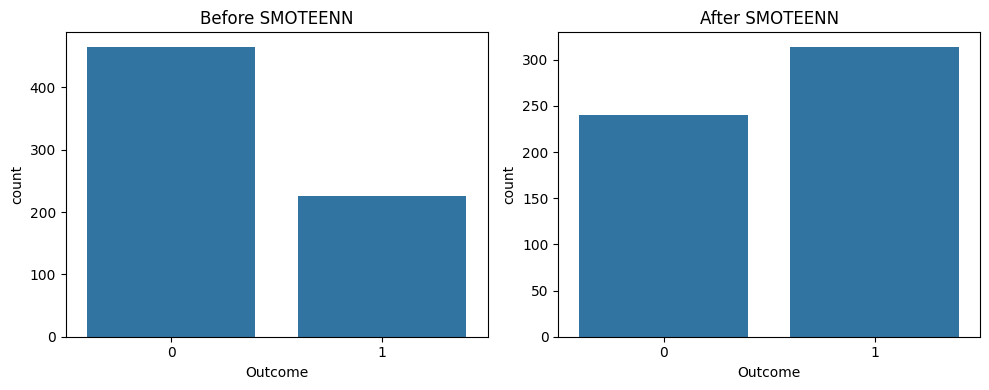

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.countplot(x=y, ax=axes[0])
axes[0].set_title("Before SMOTEENN")
sns.countplot(x=y_resampled, ax=axes[1])
axes[1].set_title("After SMOTEENN")
plt.tight_layout()
plt.show()

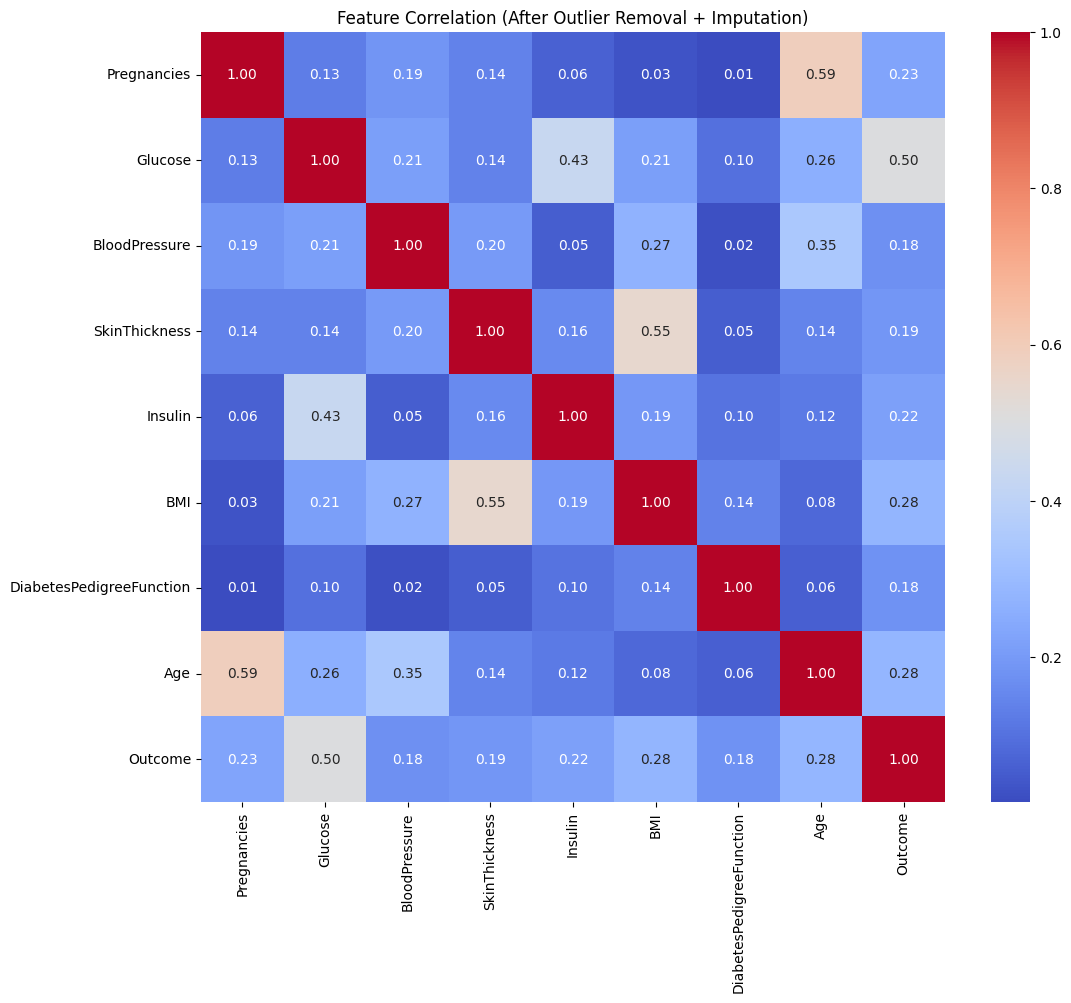

In [12]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation (After Outlier Removal + Imputation)")
plt.show()

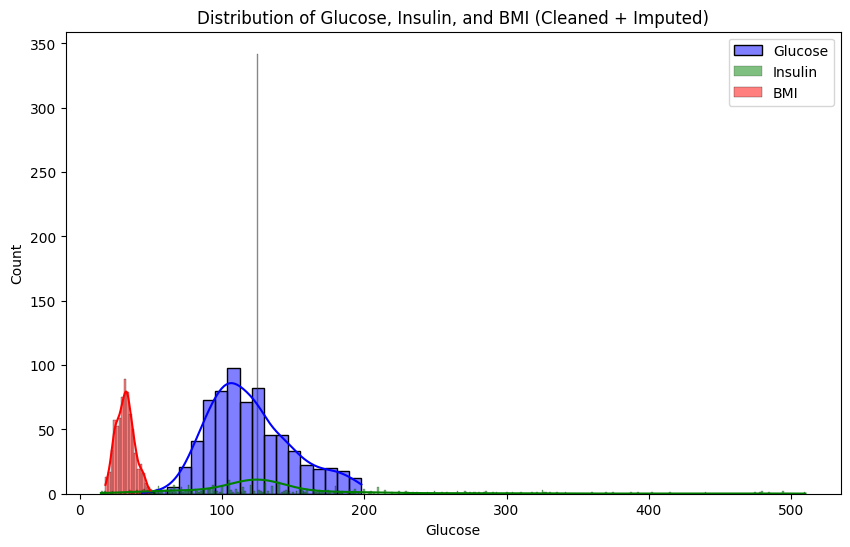

In [13]:
plt.figure(figsize=(10,6))
sns.histplot(df["Glucose"], kde=True, color="blue", label="Glucose")
sns.histplot(df["Insulin"], kde=True, color="green", label="Insulin")
sns.histplot(df["BMI"], kde=True, color="red", label="BMI")
plt.title("Distribution of Glucose, Insulin, and BMI (Cleaned + Imputed)")
plt.legend()
plt.show()

In [14]:
output_path = "pima_preprocessed_final.csv"
df_preprocessed.to_csv(output_path, index=False)
print(f"\n✅ Final preprocessed dataset saved as: {output_path}")
print(f"Final shape: {df_preprocessed.shape}")


✅ Final preprocessed dataset saved as: pima_preprocessed_final.csv
Final shape: (554, 45)
